In [1]:
#%%
from datetime import datetime
from importlib import reload
from vnpy.app.portfolio_strategy import BacktestingEngine
from vnpy.trader.constant import Interval
import pandas as pd
symbols = {
    "SHFE": ["CU", "AL", "ZN", "PB", "NI", "SN", "AU", "AG", "RB", "HC", "BU", "RU",],
    "DCE": ["C", "CS", "A", "B", "M", "Y", "P", "BB", "JD", "L", "V", "PP", "J", "JM", "I"],
    "CZCE": ["SR", "CF","PM","WH", "RI", "LR", "JR","OI", "RS", "RM", "TA", "MA", "FG", "SF", "ZC", "SM"], #  "CY", 
}
contract_type = "99"  # 99代表指数合约

In [2]:
def generate_all_vt_symbols(symbols, contract_type):
    """
    合成回测用的vt_symbol列表
    vt_symbol 格式：合约代码.交易所 （ej：AG99.SHFE）
    """
    vt_symbols = []
    for k, v in symbols.items():
        for i in v:
            symbol = i + contract_type + "." + k
            vt_symbols.append(symbol)
    return vt_symbols

In [3]:
def set_ratios(num, vt_symbols):
    """
    设置每个vt_symbol的回测参数,最终返回字典格式
    用于设置手续费，滑点，合约规模，price tick
    """
    d = {}
    for i in vt_symbols:
        d[i] = num
    return d

In [4]:
def show_result(
    vt_symbols,
    strategy,
    setting={},
    show_chart=True
):
    # 1）创建回测引擎对象
    engine = BacktestingEngine()
    # 2）设置回测参数
    engine.set_parameters(
        vt_symbols=vt_symbols,
        interval=Interval.DAILY,
        start=datetime(2006, 1, 1),
        end=datetime(2020, 12, 30),
        rates=set_ratios(1/1000, vt_symbols),  # 设置每个合约的手续费，字典格式
        slippages=set_ratios(0, vt_symbols),  #滑点，字典格式
        sizes=set_ratios(1, vt_symbols),      #合约规模，字典格式
        priceticks=set_ratios(0.01, vt_symbols), #最小价格跳动，字典格式
        capital=50_000_000,
    )
    # 3）添加策略
    engine.add_strategy(strategy, setting)
    # 4）加载历史数据
    engine.load_data()
    # 5）跑回测，基于事件引擎逐条回放，得到成交记录
    engine.run_backtesting()
    # 6）基于逐日盯市规则和成交记录，得到组合资金曲线
    df = engine.calculate_result()
    # 7）基于资金曲线，计算策略回测指标，如收益率，夏普比率
    engine.calculate_statistics()
    # 8）画图
    if show_chart:
        engine.show_chart()
        
    return strategy.show_pos, strategy.symbol_cap

In [5]:
# 生成可交易合约
all_vt_symbols = generate_all_vt_symbols(symbols, contract_type)

In [6]:
# 加载策略，一键回测
import return10_strategy
reload(return10_strategy)
pos, cap = show_result(all_vt_symbols ,return10_strategy.Return10Strategy, show_chart=True)

2021-02-06 19:21:05.345688	开始加载历史数据
2021-02-06 19:21:05.630718	CU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:21:05.941691	AL99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:21:06.205687	ZN99.SHFE历史数据加载完成，数据量：3243
2021-02-06 19:21:06.435688	PB99.SHFE历史数据加载完成，数据量：2302
2021-02-06 19:21:06.610688	NI99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:21:06.784691	SN99.SHFE历史数据加载完成，数据量：1363
2021-02-06 19:21:07.044691	AU99.SHFE历史数据加载完成，数据量：3054
2021-02-06 19:21:07.269688	AG99.SHFE历史数据加载完成，数据量：2038
2021-02-06 19:21:07.507691	RB99.SHFE历史数据加载完成，数据量：2770
2021-02-06 19:21:07.690689	HC99.SHFE历史数据加载完成，数据量：1603
2021-02-06 19:21:07.881695	BU99.SHFE历史数据加载完成，数据量：1710
2021-02-06 19:21:08.160690	RU99.SHFE历史数据加载完成，数据量：3528
2021-02-06 19:21:08.468751	C99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:21:08.648691	CS99.DCE历史数据加载完成，数据量：1424
2021-02-06 19:21:08.944692	A99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:21:09.219721	B99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:21:09.495722	M99.DCE历史数据加载完成，数据量：3528
2021-02-06 19:21:09.787691	Y99.DCE历史数据加载完成，数据量：3525
202

In [7]:
cap_df = pd.DataFrame(cap).transpose()
cap_df

CU99.SHFE   AL99.SHFE    RU99.SHFE      C99.DCE      A99.DCE  \
2006-01-03      0.0000      0.0000       0.0000       0.0000       0.0000   
2006-01-17      0.0000      0.0000       0.0000       0.0000       0.0000   
2006-02-09      0.0000      0.0000       0.0000       0.0000       0.0000   
2006-02-23  92712.8160  78846.9492   85288.8280  100748.9020  100200.8396   
2006-03-09  90751.2668  96904.4265   81493.9080   95781.7461   97088.2308   
...                ...         ...          ...          ...          ...   
2020-10-22  51988.2676  86763.5388  103549.6532  100269.6201  104401.8954   
2020-11-05  51478.3325  88312.6380   88027.3410   97052.0570  109613.5782   
2020-11-19  53527.8097  94003.6254   85513.4172  102391.7505  100411.7035   
2020-12-03  57445.0533  97253.0232  103814.1139  100200.3646   98012.8062   
2020-12-20  59289.3285  96530.3364   89671.0524   97581.6762   98783.5176   

                B99.DCE      M99.DCE    CF99.CZCE   SR99.CZCE      Y99.DCE  \
2006-01-03       0.0000       0.0000       0.0000         NaN          NaN   
2006-01-17       0.0000       0.0000       0.0000      0.0000       0.0000   
2006-02-09       0.0000       0.0000       0.0000      0.0000       0.0000   
2006-02-23   98633.5258  100251.9286   90666.4368  97892.6634   98563.5355   
2006-03-09   99483.0918   96762.7458   88533.7878  90051.6150   99190.8224   
...                 ...          ...          ...         ...          ...   
2020-10-22   96908.1126   97381.8190  101262.8344  99447.7328   98115.3306   
2020-11-05  100594.2418   99020.8851   84474.8208  97262.4554  102724.3070   
2020-11-19   97284.6250   99655.9480   99809.9956  96044.9791  100372.6022   
2020-12-03   92961.7650   96772.5605  100602.7386  95466.9231   91345.5804   
2020-12-20  102324.5392  105672.3904   90523.5636  98621.0447  100962.3368   

            ...     PP99.DCE    HC99.SHFE    MA99.CZCE    LR99.CZCE  \
2006-01-03  ...          NaN          NaN          NaN          NaN   
2006-01-17  ...          NaN          NaN          NaN          NaN   
2006-02-09  ...          NaN          NaN          NaN          NaN   
2006-02-23  ...          NaN          NaN          NaN          NaN   
2006-03-09  ...          NaN          NaN          NaN          NaN   
...         ...          ...          ...          ...          ...   
2020-10-22  ...   92696.9244   97416.5920  102954.6100  105672.0000   
2020-11-05  ...   95017.7172  100629.9528  100131.0192  108736.0000   
2020-11-19  ...  101521.1568  100440.4625  107129.2714   87328.6657   
2020-12-03  ...   92484.4877  100611.3456   96842.3984   99373.9989   
2020-12-20  ...   91638.6889  109238.9025  110782.1000       0.0000   

              SF99.CZCE    SM99.CZCE     CS99.DCE  NI99.SHFE  SN99.SHFE  \
2006-01-03          NaN          NaN          NaN        NaN        NaN   
2006-01-17          NaN          NaN          NaN        NaN        NaN   
2006-02-09          NaN          NaN          NaN        NaN        NaN   
2006-02-23          NaN          NaN          NaN        NaN        NaN   
2006-03-09          NaN          NaN          NaN        NaN        NaN   
...                 ...          ...          ...        ...        ...   
2020-10-22   99730.9539   96567.1584  101321.1080        0.0        0.0   
2020-11-05  101804.4099   98095.1040   97123.7370        0.0        0.0   
2020-11-19   98364.8480   97435.1264  102401.8065        0.0        0.0   
2020-12-03  105808.3920  103895.0832  101381.8936        0.0        0.0   
2020-12-20  101879.3880  103945.9395   97955.0781        0.0        0.0   

              ZC99.CZCE  
2006-01-03          NaN  
2006-01-17          NaN  
2006-02-09          NaN  
2006-02-23          NaN  
2006-03-09          NaN  
...                 ...  
2020-10-22   95312.7180  
2020-11-05  103993.2924  
2020-11-19   99694.0902  
2020-12-03  113347.1752  
2020-12-20  105140.9121  

[353 rows x 43 columns]

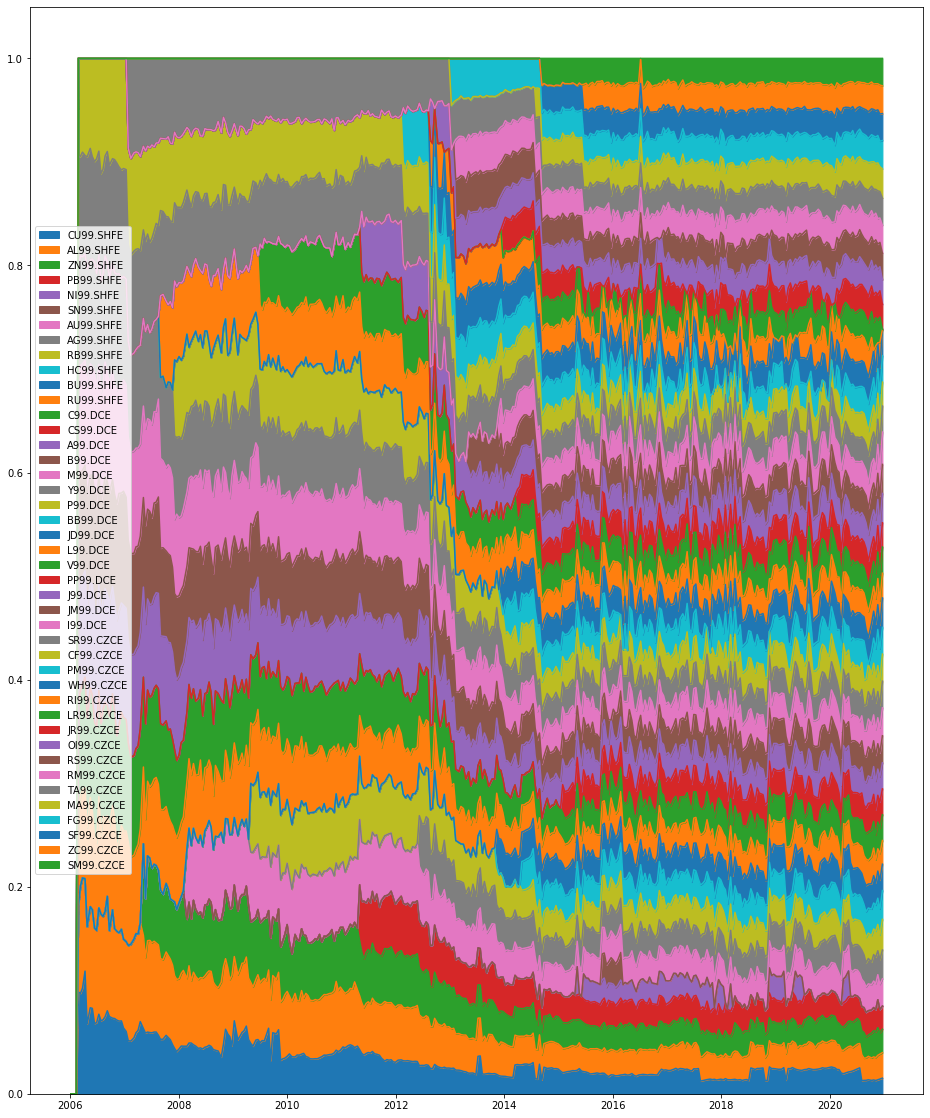

In [16]:
sum_df = pd.DataFrame()
dev_cap = pd.DataFrame()
sum_df['Sum'] = cap_df.apply(lambda x: x.sum(), axis=1)
for vt_symbol in all_vt_symbols:
    dev_cap[vt_symbol] = cap_df[vt_symbol] / sum_df['Sum']
dev_cap.plot(kind='area',figsize=(16,20),stacked=True)   